# Clustering with fixed numbers of clusters


The task is to assign samples from an intractable target distributions to $K$ clusters, where $K$ is given as part of the challenge parameters, in order to achieve a high cluster pairwise connectivity score. Target distribution samples are generated by pass unit Gaussian samples through a small multi-layer perceptron transformation. 


### Table of contents
1. [Run LLM-innovation loop](#loop)
2. [Visualise KDE instances](#visualise)

In [22]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt


import template

<a id="2D"></a>
## 1. Example 2D challenge target distribution samples

In [23]:
seed = 12349
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 12
z = rng_samps.normal(size=(num_samples, 2))

x = template.generate_samples(rng_params, z, width=12, layers=5)

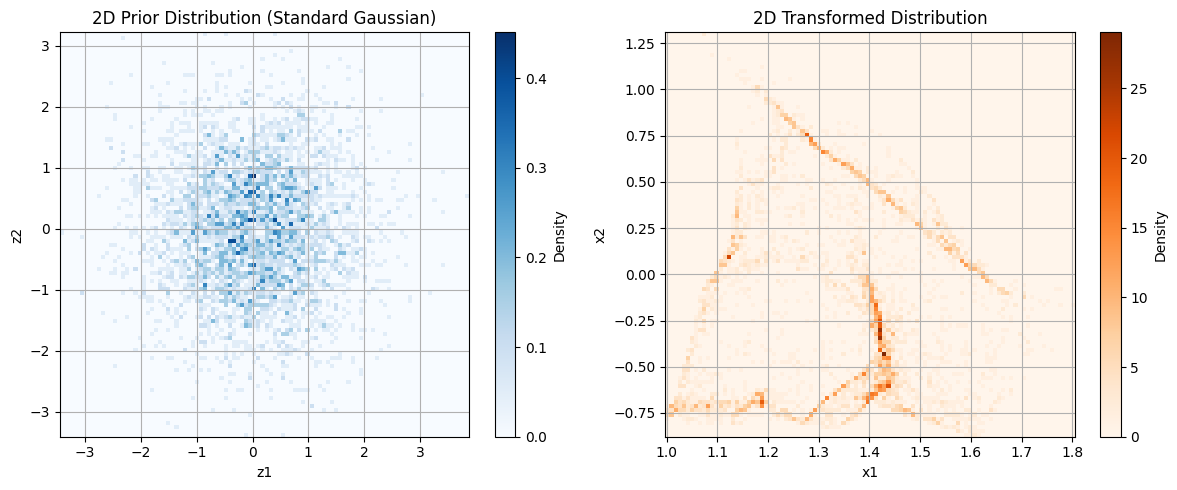

In [24]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist2d(z[:, 0], z[:, 1], bins=100, density=True, cmap='Blues')
plt.colorbar(label="Density")
plt.title("2D Prior Distribution (Standard Gaussian)")
plt.xlabel("z1")
plt.ylabel("z2")
#plt.axis("equal")
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist2d(x[:, 0], x[:, 1], bins=100, density=True, cmap='Oranges')
plt.colorbar(label="Density")
plt.title("2D Transformed Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
#plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()

<a id="visual"></a>
## 2. Visualising simple clustering algorithms and cluster quality scores

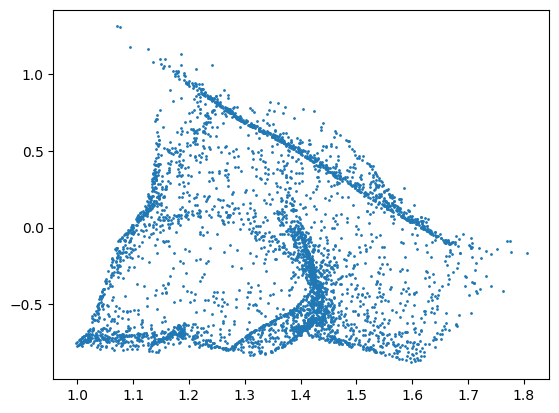

In [25]:
plt.scatter(x[:, 0], x[:, 1], s=1)
plt.show()

We consider a simple **pairwise connectivity score** (lower is better, 0 is perfect cluster), which can be written as:

$$
\text{ConnectivityScore} = \sum_{i=1}^{n} \sum_{j \in \mathcal{N}_i} \frac{1}{\text{rank}_{ij}} \cdot \mathbb{1}[c_i \ne c_j]
$$

* $n$: total number of data points.
* $\mathcal{N}_i$: the set of $k$-nearest neighbors of point $x_i$ (excluding $x_i$ itself).
* $\text{rank}_{ij}$: the rank (1-indexed) of point $x_j$ in $x_i$'s nearest neighbors (i.e., 1 if closest, 2 if second closest, etc.).
* $c_i$: cluster label of point $x_i$.
* $\mathbb{1}[c_i \ne c_j]$: indicator function, equal to 1 if $x_i$ and $x_j$ are in different clusters, 0 otherwise.

### Intuition:

* Penalizes neighbors that are split across clusters.
* Penalizes more heavily when closer neighbors (low rank) are misclustered.

In [30]:
from sklearn.datasets import make_moons, make_circles
from sklearn.cluster import KMeans, SpectralClustering


# Prepare datasets
datasets = {
    "Moons": make_moons(n_samples=300, noise=0.05, random_state=42),
    "Circles": make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    "Challenge instance": (x, None), #make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=42)
}

# Algorithms to compare
clusterers = {
    "KMeans": lambda X: KMeans(n_clusters=3, n_init=10, random_state=42).fit_predict(X),
    "Spectral": lambda X: SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42).fit_predict(X)
}

/Users/Shared/Learning/TIG-LLM-innovator-MVP/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/Shared/Learning/TIG-LLM-innovator-MVP/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


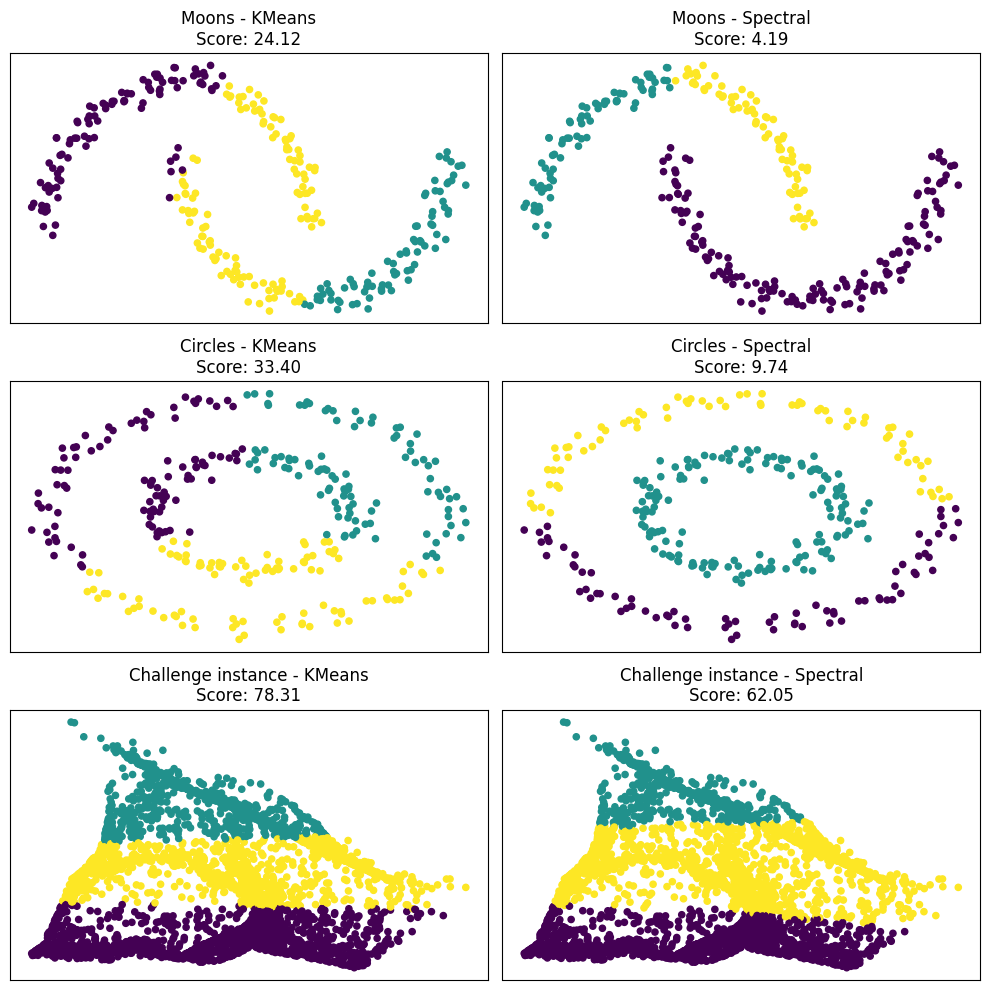

In [ ]:
# Store results for visualization
results = []

for ds_name, (X, _) in datasets.items():
    for algo_name, algo in clusterers.items():
        labels = algo(X)
        score = template.pairwise_connectivity_score(X, labels, n_neighbors=10)
        results.append((ds_name, algo_name, X, labels, score))

# Plot results
fig, axes = plt.subplots(len(datasets), len(clusterers), figsize=(10, 10))
for idx, (ds_name, algo_name, X, labels, score) in enumerate(results):
    i = list(datasets.keys()).index(ds_name)
    j = list(clusterers.keys()).index(algo_name)
    ax = axes[i, j]
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=20)
    ax.set_title(f"{ds_name} - {algo_name}\nScore: {score:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
